This notebook will be used to develop and compare regression models to correlate the eHydro bathymetric surveys with cloud-masked Sentinel-2 surface refelctances. These models will hopefully provide USACE and the eHydro program with a new, robust, accurate tool for unmanned bathymetric estiamtes. This will be possible at 10-meter resolution at a frequency of up to 5 days.
- First starting with XGBoost, RF, and SVM-RBF regressors in the SWG. May try some NN as well
- band maths here with the green and blue bands (short wavelengths penetrate water columns more)
- include some metadata (AD, CX, BD? Single vs dual beam?)? Will look into more that may be beneficial

In [1]:
import os
import re
import pickle
import rasterio
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Functions

In [2]:
# Function to normalize an array
def normalize(array):
    return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

# Function to read .tif files
def read_tif(file_path):
    with rasterio.open(file_path) as src:
        array = src.read()  # Read all bands
        profile = src.profile  # Get metadata (optional, for reference)
    return array, profile

def extract_raster_data(pair_tuple):
    images_data = []

    bathy_path = pair_tuple[1]
    s2_path = pair_tuple[0]

        # --- Step 1: Open Bathymetry Raster ---
    with rasterio.open(bathy_path) as bathy:
        bathy_data = bathy.read(1)  # Bathymetry data (band 1)
        bathy_nodata = bathy.nodata  # NoData value
        bathy_transform = bathy.transform
        bathy_shape = bathy.shape

        # --- Step 2: Open Sentinel-2 Raster ---
    with rasterio.open(s2_path) as s2:
        if s2.shape != bathy_shape or s2.transform != bathy_transform:
            raise ValueError(
                f"Inconsistent shapes or transforms:\n"
                f"Bathymetry Shape: {bathy_shape}, Sentinel-2 Shape: {s2.shape}.\n"
                f"Bathymetry Transform: {bathy_transform}, Sentinel-2 Transform: {s2.transform}.\n"
                f"Ensure rasters have identical extents and resolutions."
            )
        
        # Read Sentinel-2 bands
        bands = {
            "red": normalize(s2.read(3)),
            "green": normalize(s2.read(2)),
            "blue": normalize(s2.read(1)),
            "nir": normalize(s2.read(4)),
            "blue/green": normalize(s2.read(1) / s2.read(2)),
            "green/blue": normalize(s2.read(2) / s2.read(1)),
            "stumpf": normalize(np.log(s2.read(1) / np.log(s2.read(2))))
        }

    # transformed_bands = quantile_transform(bands)
    s2_nodata = s2.nodata  # Sentinel-2 NoData value

    # --- Step 3: Flatten Bands ---
    flat_bathy = bathy_data.flatten()
    flat_bands = {key: band.flatten() for key, band in bands.items()}

    # --- Step 4: Mask NoData Values ---
    valid_mask = (
        ~np.isnan(flat_bathy) &  # Valid bathy pixels
        (flat_bathy != bathy_nodata)  # Exclude bathy NoData
    )

    for band in flat_bands.values():
        valid_mask &= (band != s2_nodata)  # Exclude Sentinel-2 NoData
        
        
    # Apply the mask
    valid_bathy = flat_bathy[valid_mask].reshape(-1, 1)  # Reshape bathy to (n_pixels, 1)
    valid_features = np.column_stack([band[valid_mask] for band in flat_bands.values()])

    # --- Step 5: Combine Features and Targets ---
    # combined_features = np.concatenate((valid_bathy, valid_features), axis=1)  # Combine bathy and S2
    images_data.append((valid_features, valid_bathy.flatten()))  # Flatten bathy for targets

    return images_data

def prepare_data(pairs):
    X = []
    y = []
    for features, targets in pairs:
        X.append(features[:,1:])  # Keep features from this pair
        y.append(targets)   # Keep corresponding targets
    return np.vstack(X), np.hstack(y)

def survey_name_type(surveynames):
    """
    Will take in the list of surveynames and extract the NCF channel ID and the survey type
    """
    surveytypes = ['AD', 'BD', 'CS', 'PA', 'PR', 'XA', 'XB', 'XC', 'OT', 'DS']

    extracted_parts = [re.match(r'^(.*?)_\d{8}', path).group(1) for path in surveynames if re.match(r'^(.*?)_\d{8}', path)]
    channel_ids = [re.sub(r'^.*?_DIS_', '', path) for path in extracted_parts]

    isolated_survey_types = []
    for path in surveynames:
        for type in surveytypes:
            if type in path:
                isolated_survey_types.append(type)
                break  # Stop checking after the first match

    return channel_ids, isolated_survey_types

def create_composite_bands_with_existing(flattened_s2):
    if flattened_s2.shape[1] != 4:
        raise ValueError("Input array must have 4 columns representing B, G, R, NIR bands.")

    # Split the bands
    blue = flattened_s2[:, 0]
    green = flattened_s2[:, 1]

    # Compute composite bands
    with np.errstate(divide='ignore', invalid='ignore'):
        bluegreen = np.divide(blue, green, out=np.zeros_like(blue), where=green != 0)
        greenblue = np.divide(green, blue, out=np.zeros_like(green), where=blue != 0)
        stumpf = np.divide(
            np.log(blue + 1e-6), np.log(green + 1e-6), out=np.zeros_like(blue), where=(green > 0) & (blue > 0)
        )

    # Normalize composite bands
    bluegreen = normalize(bluegreen)
    greenblue = normalize(greenblue)
    stumpf = normalize(stumpf)

    # Combine all bands
    combined_array = np.hstack((flattened_s2, bluegreen[:, None], greenblue[:, None], stumpf[:, None]))

    return combined_array

def get_pixel_positions(raster_path):
    with rasterio.open(raster_path) as src:
        # Get the affine transformation of the raster
        transform = src.transform
        
        # Read the first band to determine valid (non-NaN) pixels
        band_data = src.read(1, masked=True)  # Read the first band as a masked array
        valid_mask = ~band_data.mask          # Valid pixels where mask is False

        # Get raster dimensions
        height, width = src.height, src.width

        # Create arrays of pixel indices
        row_indices, col_indices = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")

        # Compute x, y positions using the affine transform
        xs, ys = rasterio.transform.xy(transform, row_indices, col_indices, offset='center')
        xs = np.array(xs).flatten()
        ys = np.array(ys).flatten()

        # Filter x, y positions to include only valid pixels
        valid_positions = np.column_stack((xs[valid_mask.flatten()], ys[valid_mask.flatten()]))

    return valid_positions

def prepare_train_data(surveynames):
    pairs = [(os.path.join(S2_PATH, f'{name}.tif'), os.path.join(BATHY_PATH, f'{name}.tif')) for name in surveynames]
    
    good_pairs = []
    goodnames = []
    for name, pair in zip(surveynames, pairs):
        with rasterio.open(pair[0]) as src:
            band = src.read(1)
            if band.shape[0] != 0:
                good_pairs.append(pair)
                goodnames.append(name)

    images_data = [extract_raster_data(pair) for pair in good_pairs]
    ncf_channels, survey_types = survey_name_type(goodnames)
    # all_bands = [create_composite_bands_with_existing(pair[0]) for pair in images_data]
    pixel_positions = [get_pixel_positions(os.path.join(S2_PATH, f'{name}.tif')) for name in goodnames]
    
    data = {}

    for i, name in enumerate(goodnames):
        # Extract data for the current iteration
        bands = images_data[i]               # Shape (n_pixels, 7)
        positions = pixel_positions[i]     # Shape (n_pixels, 2)
    
        data[name] = pd.DataFrame({
                "Blue": bands[0][0][:, 0],
                "Green": bands[0][0][:, 1],
                "Red": bands[0][0][:, 2],
                "NIR": bands[0][0][:, 3],
                "Blue/Green": bands[0][0][:, 4],
                "Green/Blue": bands[0][0][:, 5],
                "Stumpf": bands[0][0][:, 6],
                "X": positions[:, 0],
                "Y": positions[:, 1],
                "Channel_Name": [ncf_channels[i]] * len(bands[0][0]),  # Repeating value directly
                "Bathymetry": bands[0][1]
            })

    combined_df = pd.concat(data.values(), ignore_index=True)

    encoder = LabelEncoder()
    combined_df['Channel_Name_Encoded'] = encoder.fit_transform(combined_df['Channel_Name'])

    output = open(os.path.join(WORK_DIR, 'Channel_Name_label_encoders.pkl'), 'wb')
    pickle.dump(encoder, output)
    output.close()
    
    # Drop original categorical columns
    combined_df.drop(columns=['Channel_Name'], inplace=True)

    X = combined_df.drop(columns=['Bathymetry'])
    y = combined_df['Bathymetry']

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

    # Split temp into validation (15%) and test (15%)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return data, combined_df, X_train, y_train, X_test, y_test, X_val, y_val

def plot_histograms(df):
    num_columns = min(7, len(df.columns))  # Limit to 7 columns
    plt.figure(figsize=(15, 10))  # Adjust the figure size

    for i in range(num_columns):
        plt.subplot(3, 3, i + 1)  # Create a grid for plots (3x3 max)
        column = df.columns[i]
        plt.hist(df[column], bins=100, alpha=0.75, color='blue', edgecolor='black')
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


# Establish working directories

In [3]:
# your work directory
WORK_DIR = '/home/clay/Documents/SDB/CESWG'

S2_PATH =os.path.join(WORK_DIR, 'processed/S2')
BATHY_PATH = os.path.join(WORK_DIR,'processed/Bathy')

In [4]:
surveynames = [f[:-4] for f in os.listdir(BATHY_PATH) if f.endswith('.tif')]

# Sentinel-2 band manipulation and including other data (good reference is Chybicki et al. 2023)
- Blue Green ratios (Blue/Green, Green/Blue, looking for others)
- Stumpf log ratio of blue green (https://aslopubs.onlinelibrary.wiley.com/doi/10.4319/lo.2003.48.1_part_2.0547)
- Coordinates
- NCF channel ID name
- Survey type
- Spectral indices?? (NDVI and NDWI, NDWI could make sense but would leave this to the end)


The Chybicki 2023 paper had models perform extremely well when including all bands, the Stumpf log ratio, and the UTM coordinates. I think including more blue-green ratios and the survey type as well will increase my accuracy

In [5]:
all_data, combined_data, X_train, y_train, X_test, y_test, X_val, y_val = prepare_train_data(surveynames)

/tmp/ipykernel_38783/171453358.py:3: RuntimeWarning: All-NaN slice encountered
  return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))
/tmp/ipykernel_38783/171453358.py:3: RuntimeWarning: invalid value encountered in divide
  return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))
/tmp/ipykernel_38783/171453358.py:43: RuntimeWarning: divide by zero encountered in divide
  "stumpf": normalize(np.log(s2.read(1) / np.log(s2.read(2))))
/tmp/ipykernel_38783/171453358.py:41: RuntimeWarning: divide by zero encountered in divide
  "blue/green": normalize(s2.read(1) / s2.read(2)),
/tmp/ipykernel_38783/171453358.py:43: RuntimeWarning: divide by zero encountered in log
  "stumpf": normalize(np.log(s2.read(1) / np.log(s2.read(2))))
/tmp/ipykernel_38783/171453358.py:43: RuntimeWarning: invalid value encountered in log
  "stumpf": normalize(np.log(s2.read(1) / np.log(s2.read(2))))
/tmp/ipykernel_38783/171453358.py:3: RuntimeWarning: invalid value encountered in 

train


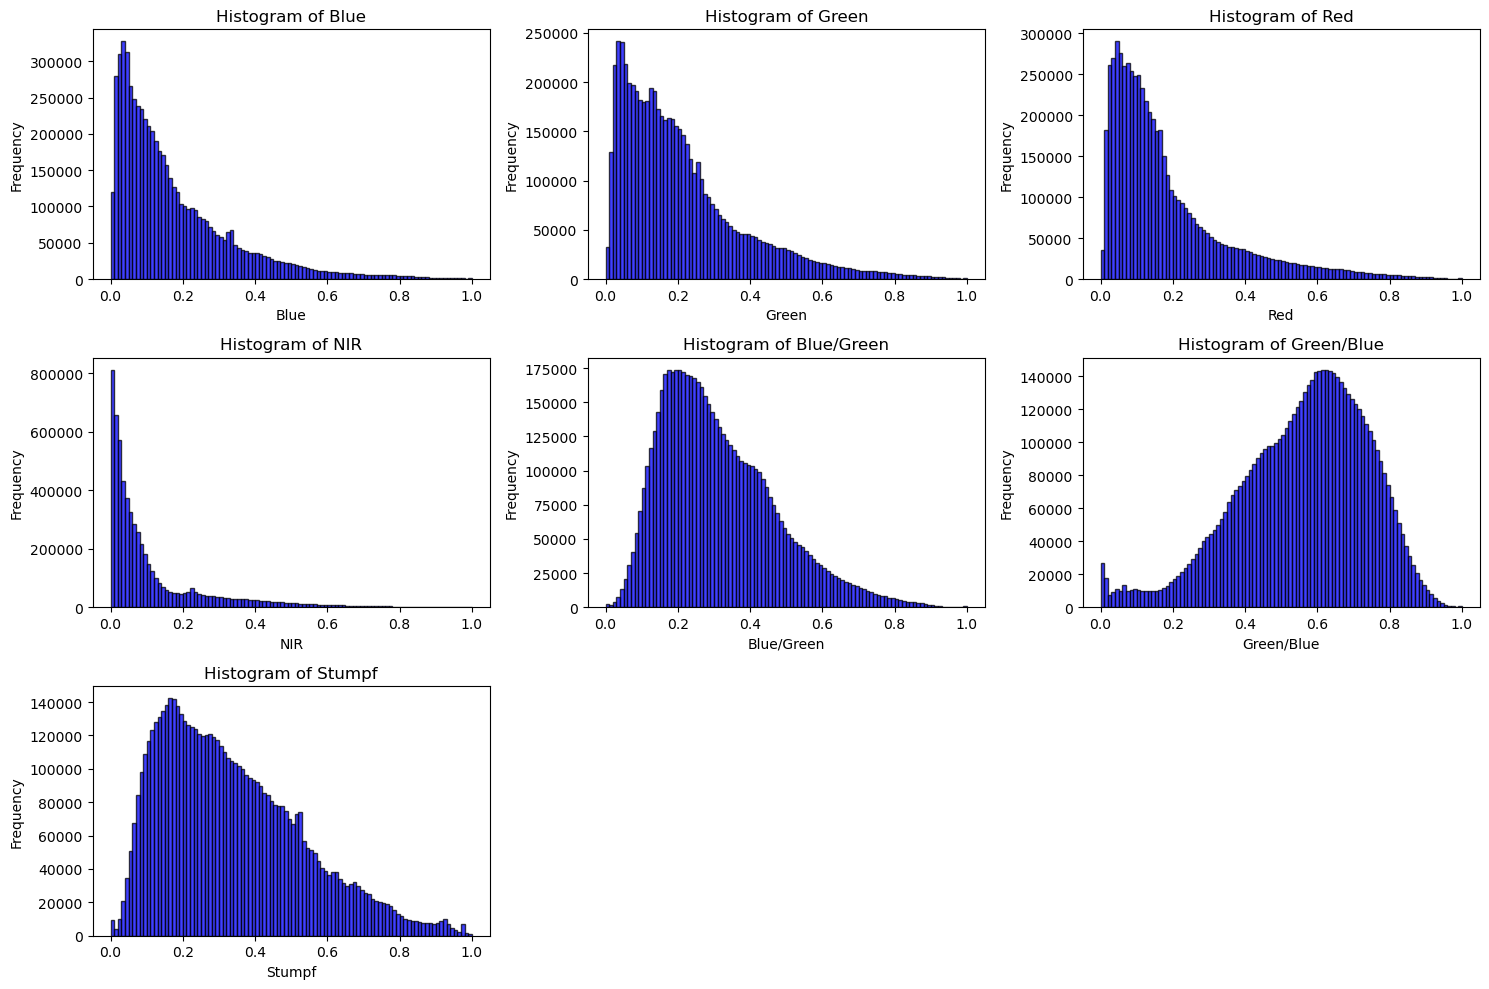

test


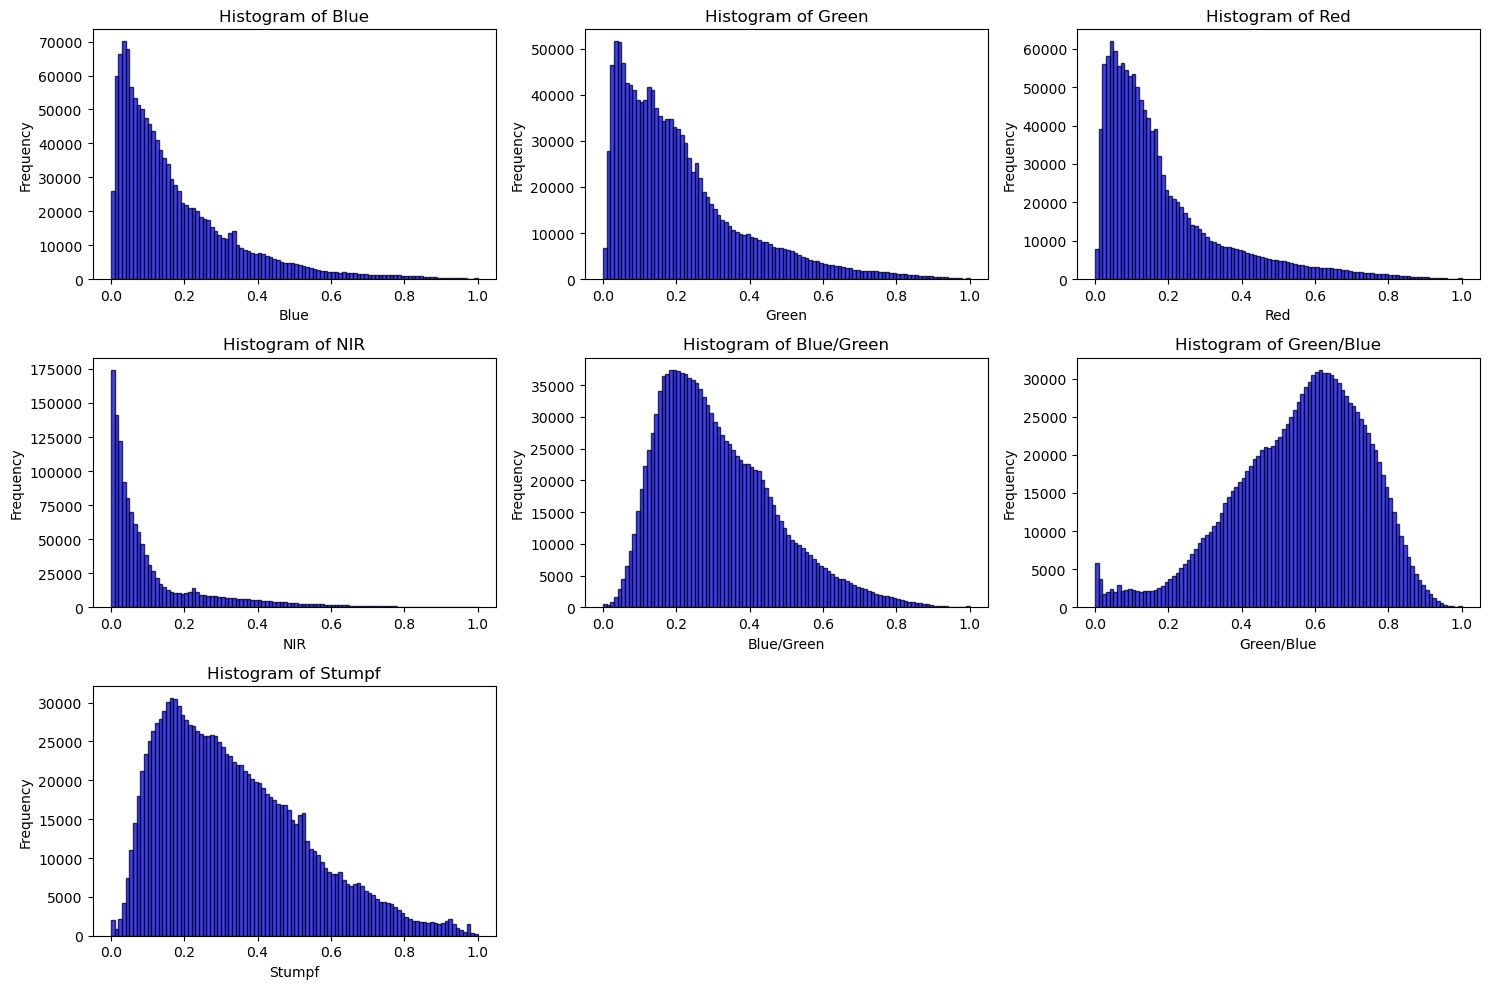

val


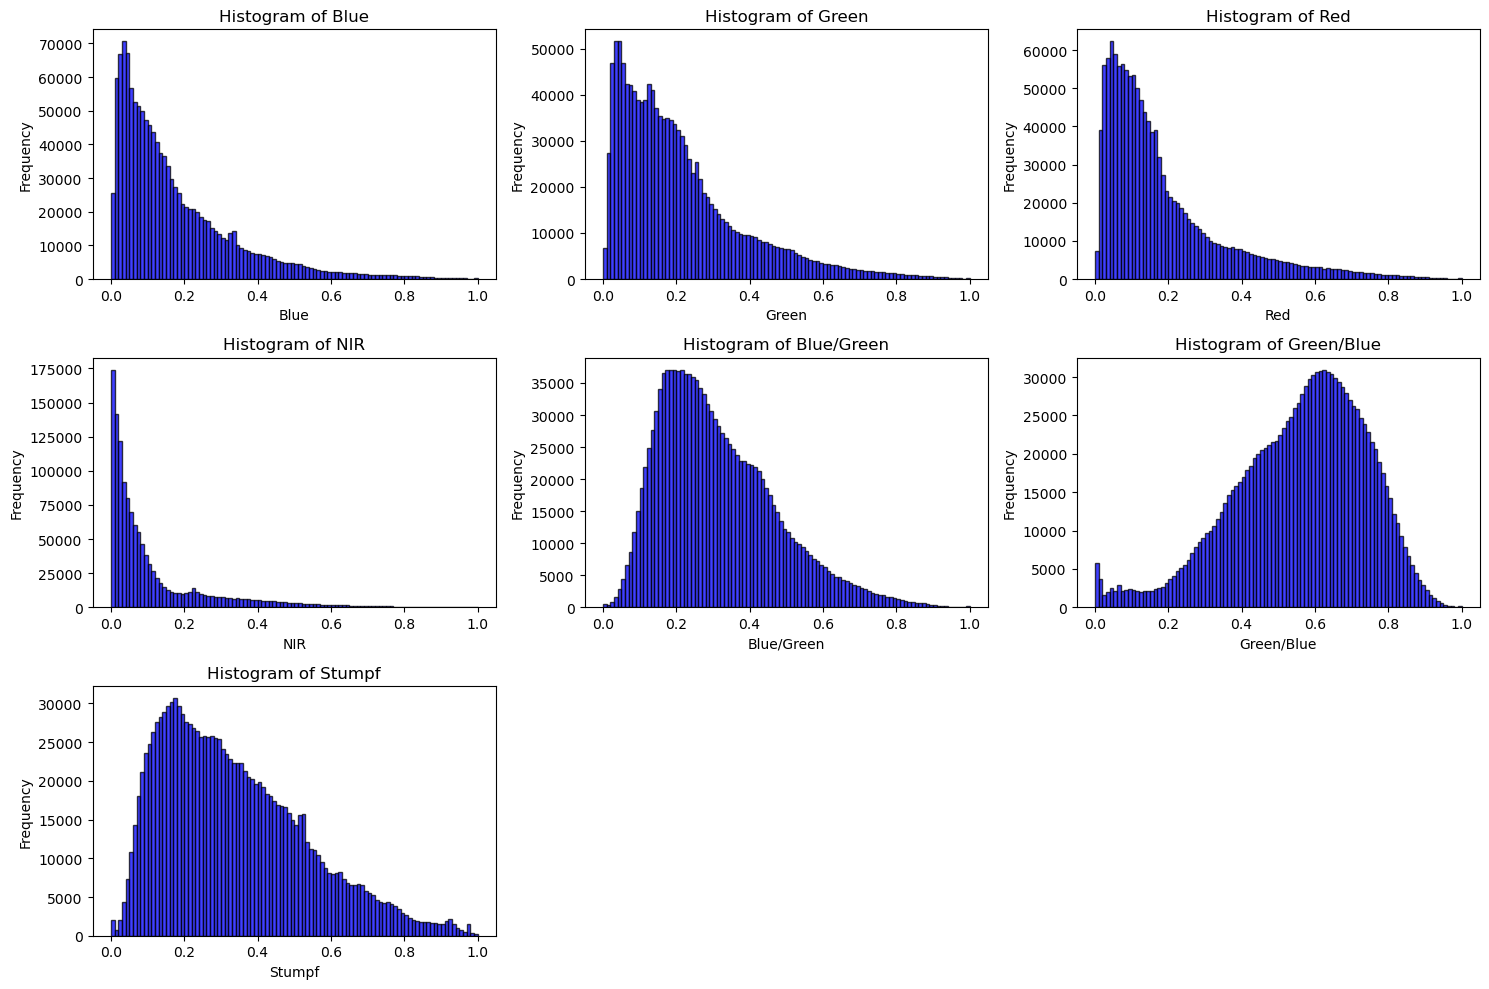

In [10]:
for name, set in zip(['train', 'test', 'val'],[X_train, X_test, X_val]):
    print(name)
    plot_histograms(set)

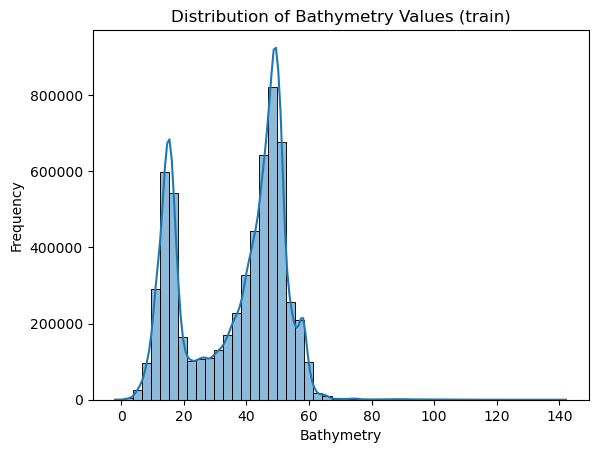

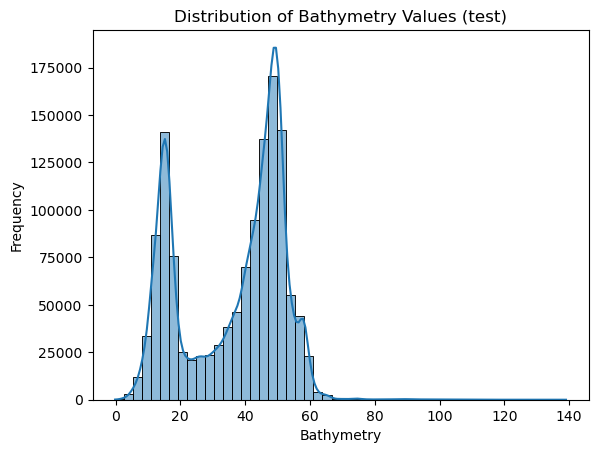

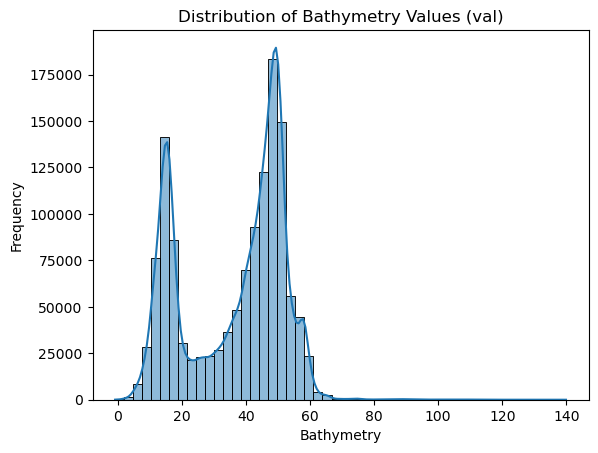

In [9]:
for name, set in zip(['train', 'test', 'val'], [y_train, y_test, y_val]):
    sns.histplot(set, kde=True, bins=50)
    plt.title(f"Distribution of Bathymetry Values ({name})")
    plt.xlabel("Bathymetry")
    plt.ylabel("Frequency")
    plt.show()


# Prepare data for test_train_split
- Trains per pixel


- k-fold segmentation for training?
- try 3 regression models for now: SVM, RF, and XGBoost
- may try ElasticNet from cuML, and some shallow NNs

In [11]:
# Confirm dataset sizes
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 6088268
Validation set size: 1304629
Testing set size: 1304629


1. RF Regression:

Try cross-validation, and binneed splitting to ensure less bias during training?

For gridsearch param tuning:
1. {'criterion': 'squared_error',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 200}
2. {'criterion': 'squared_error',
 'max_depth': 12,
 'max_features': 'sqrt',
 'n_estimators': 100}
3. {'criterion': 'squared_error',
 'max_depth': 20,
 'max_features': 'sqrt',
 'n_estimators': 100}
 4. 

In [ ]:
param_grid = {
    'min_samples_split': [2, 8],
    'max_features': ['sqrt'],
    'criterion' :['squared_error'],
    'min_samples_leaf': [1, 2]
}

rfr = RandomForestRegressor(n_jobs=18, random_state=42)
# rfr.fit(X_train, y_train)

CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 5)
CV_rfr.fit(X_train, y_train)
CV_rfr.best_params_

After 191min of training (initial run)
- R2 Score: 0.9818
- RMSE: 2.1344      (ft)
- MAE: 1.0686       (ft)

In [12]:
X = combined_data.drop(['Bathymetry'], axis=1)
y = combined_data['Bathymetry']

In [13]:
# Random Forest Model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth= None, 
    criterion='squared_error',  
    min_weight_fraction_leaf=0.0, 
    max_features='sqrt',                   # 'sqrt', 'log2', int, or float
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=18, 
    random_state=42, 
    verbose=0, 
    warm_start=False, 
    ccp_alpha=0.0, 
    max_samples=None, 
    monotonic_cst=None
)

# rf_model.fit(X_train, y_train)
scores = -1 * cross_val_score(rf_model, X, y, cv=3, scoring= 'neg_root_mean_squared_error', n_jobs=18)
display(scores.mean())

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [184]:
train_val_metrics = {}

for pair in zip([X_test, X_val], [y_test, y_val], ['test', 'val']):
    predictions = rf_model.predict(pair[0])

    train_val_metrics[pair[2]] = [r2_score(pair[1], predictions), np.sqrt(mean_squared_error(pair[1], predictions)), mean_absolute_error(pair[1], predictions)]

In [185]:
for key in list(train_val_metrics.keys()):
    print(train_val_metrics[key])

[0.9394653883890526, np.float64(3.8892752017609955), 2.329548394748036]
[0.9395564248621846, np.float64(3.885519192325711), 2.328350710126916]


In [ ]:
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

2. XGBoost Regression

n_estimators=500, learning_rate=0.3, max_depth=10, grow_policy= 'lossguide', booster= 'gbtree',:
- R2 Score= 0.8529
- RMSE= 6.0626
- MAE= 3.9175

In [ ]:
# Define and configure the XGBoost regressor
xgb_model = XGBRegressor(
    n_estimators=500,      # Number of trees
    learning_rate=0.3,     # Learning rate
    max_depth=10,           # Maximum tree depth
    grow_policy= 'lossguide',
    booster= 'gbtree',
    random_state=42        # Random seed for reproducibility
)

# Train the model
xgb_model.fit(
    X_train, y_train
)

In [ ]:
xgb_predictions = xgb_model.predict(X_test)

r2 = r2_score(y_test, xgb_predictions)
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
mae = mean_absolute_error(y_test, xgb_predictions)
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

In [ ]:
val_predictions = xgb_model.predict(X_val)

r2 = r2_score(y_val, val_predictions)
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
mae = mean_absolute_error(y_val, val_predictions)
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

3. SVM regression:
- R2 Score: 
- RMSE: 
- MAE: 

In [ ]:
# Support Vector Machine Model
svm_model = SVR()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)


r2 = r2_score(y_test, svm_predictions)
rmse = np.sqrt(mean_squared_error(y_test, svm_predictions))
mae = mean_absolute_error(y_test, svm_predictions)
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")